In [1]:
import pandas as pd
import numpy as np
import warnings
import time

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.model_selection import train_test_split

from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore')

/Users/benmagevney/miniconda/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# read datasets 
enc = pd.read_csv('../../data/regional_datasets/univariate/enc_data_univ.csv')
esc = pd.read_csv('../../data/regional_datasets/univariate/esc_data_univ.csv')
mid_atlantic = pd.read_csv('../../data/regional_datasets/univariate/mid_atlantic_data_univ.csv')
mountain = pd.read_csv('../../data/regional_datasets/univariate/mountain_data_univ.csv')
new_england = pd.read_csv('../../data/regional_datasets/univariate/new_england_data_univ.csv')
pacific = pd.read_csv('../../data/regional_datasets/univariate/pacific_data_univ.csv')
south_atlantic = pd.read_csv('../../data/regional_datasets/univariate/south_atlantic_data_univ.csv')
wnc = pd.read_csv('../../data/regional_datasets/univariate/wnc_data_univ.csv')
wsc = pd.read_csv('../../data/regional_datasets/univariate/wsc_data_univ.csv')
datasets = [enc, esc, mid_atlantic, mountain, new_england, pacific, south_atlantic, wnc, wsc]
for df in datasets:
    df.set_index(pd.to_datetime(df['date']), inplace=True)
    df.drop(columns=["Unnamed: 0", "date"], axis=1, inplace=True)
    df.sort_index(inplace=True)
    


In [3]:
# ignore values before march 
enc = enc[enc.index >= "2020-03-01"]
esc = esc[esc.index >= "2020-03-01"]
mid_atlantic = mid_atlantic[mid_atlantic.index >= "2020-03-01"]
mountain = mountain[mountain.index >= "2020-03-01"]
new_england = new_england[new_england.index >= "2020-03-01"]
pacific = pacific[pacific.index >= "2020-03-01"]
south_atlantic = south_atlantic[south_atlantic.index >= "2020-03-01"]
wnc = wnc[wnc.index >= "2020-03-01"]
wsc = wsc[wsc.index >= "2020-03-01"]

## Sarimax

In [18]:
# def build_sarima_model(df, params=None, seasonal_params=None, plot=False):
#     region = df["region"].iloc[0]
#     print(f"Training model for {region}...")

#     size = round(df.shape[0]*0.15)
#     train = df.iloc[:-size]['new_confirmed']
#     test = df.iloc[-size:]['new_confirmed']

#     if params and seasonal_params:
#          model = SARIMAX(train, order=params, seasonal_order=seasonal_params)
#     elif params:
#         model = SARIMAX(train, order=params, seasonal_order=(1, 1, 1,7))
#     else:
#         model = SARIMAX(train, order=(2, 0, 3), seasonal_order=(1, 1, 1,7))
#     model_fit = model.fit(disp=False)

#     pred = model_fit.forecast(steps=size)    

#     # calculate metrics
#     mae = mean_absolute_error(test, pred)
#     mse = mean_squared_error(test, pred)
#     rmse = mean_squared_error(test, pred, squared=False)
#     mase = mean_absolute_scaled_error(test, pred, y_train=train)
#     print(f'MAE: {round(mae, 2)}')
#     print(f'MSE: {round(mse, 2)}')
#     print(f'RMSE: {round(rmse, 2)}')
#     print(f'MASE: {round(mase, 2)}')

#     # plot predictions
#     if plot:
#         plt.figure(figsize=(15, 5))
#         plt.title(f'SARIMA Predictions for {region}')
#         plt.plot(test.index, test, label='True')
#         plt.plot(pred.index, pred, label='Predicted')
#         plt.legend() 
#         plt.show()



In [22]:
def build_baseline_model(df, params=None, seasonal_params=None, plot=False, test_perf = False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    train_df, temp_test_df = train_test_split(df, test_size=0.2, shuffle=False)
    val_df, test_df  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)

    train = train_df['new_confirmed']
    test = test_df['new_confirmed']
    val = val_df['new_confirmed']
    train_val = pd.concat([train, val])


    if not params:
        params = (4, 1, 4)
    if not seasonal_params:
        seasonal_params = (1, 1, 1, 7)
    
    model = SARIMAX(train, order=params, seasonal_order=seasonal_params)
    model_fit = model.fit(disp=False)

    val_pred = model_fit.forecast(steps=len(val))    

    # calculate metrics
    mae = round(mean_absolute_error(val, val_pred), 2)
    rmse = round(mean_squared_error(val, val_pred, squared=False), 2)
    mase = round(mean_absolute_scaled_error(val, val_pred, y_train=train), 2)
    aic = round(model_fit.aic, 2)

    print(f"Validatation Stats= AIC: {aic}, MASE: {mase}, RMSE: {rmse}, MAE: {mae}")

    # plot predictions
    if plot and not test_perf:
        plt.figure(figsize=(15, 5))
        plt.title(f'Validation SARIMA Predictions for {region}')
        plt.plot(val.index, val, label='True Val')
        plt.plot(val_pred.index, val_pred, label='Predicted')
        plt.legend() 
        plt.show()

    if test_perf:
        model = SARIMAX(train, order=params, seasonal_order=seasonal_params)
        model_fit = model.fit(disp=False)

        test_pred = model_fit.forecast(steps=len(test))
        mae = round(mean_absolute_error(test, test_pred), 2)
        rmse = round(mean_squared_error(test, test_pred, squared=False), 2)
        mase = round(mean_absolute_scaled_error(test, test_pred, y_train=train_val), 2)
        aic = round(model_fit.aic, 2)

        print(f"Test Stats= AIC: {aic}, MASE: {mase}, RMSE: {rmse}, MAE: {mae}")
        
        # plot both validation and test
        # if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'ARIMA Predictions for {region}')
        plt.plot(val.index, val, label='True Val', color="#1f77b4")
        plt.plot(val_pred.index, val_pred, label='Val Predicted', color="purple")
        plt.plot(test.index, test, label='True Test', color="#1f77b4")
        plt.plot(test_pred.index, test_pred, label='Test Predicted', color="#ff7f0e")
        plt.legend() 
        plt.show()



In [23]:
params = {
    "East North Central": (7, 0, 5),
    "East South Central": (8, 1, 8),
    "Mid-Atlantic": (6, 0, 8),
    "Mountain": (7, 1, 7),  
    "New England": (8, 0, 5),
    "Pacific": (8, 1, 6),
    "South Atlantic": (8, 0, 5),
    "West North Central": (5, 1, 6),
    "West South Central": (8, 1, 8),
}

Training model for East North Central...
Validatation Stats= AIC: 16239.85, MASE: 2.37, RMSE: 23910.23, MAE: 19423.98
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08864D+01    |proj g|=  6.86597D-01


 This problem is unconstrained.



At iterate    5    f=  1.05330D+01    |proj g|=  1.74135D-02

At iterate   10    f=  1.05305D+01    |proj g|=  2.60736D-02

At iterate   15    f=  1.05113D+01    |proj g|=  4.48779D-02

At iterate   20    f=  1.04981D+01    |proj g|=  5.19917D-03

At iterate   25    f=  1.04972D+01    |proj g|=  1.78043D-02

At iterate   30    f=  1.04940D+01    |proj g|=  3.15344D-02

At iterate   35    f=  1.04859D+01    |proj g|=  4.08422D-02

At iterate   40    f=  1.04784D+01    |proj g|=  2.90392D-02

At iterate   45    f=  1.04770D+01    |proj g|=  5.81996D-03

At iterate   50    f=  1.04766D+01    |proj g|=  9.80646D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

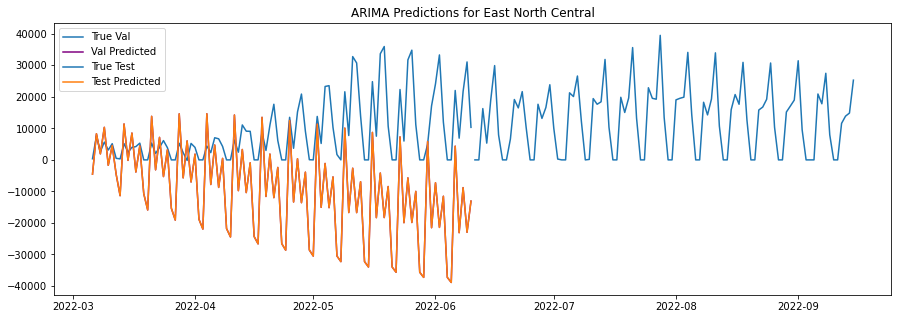


Training model for East South Central...
Validatation Stats= AIC: 15462.25, MASE: 1.95, RMSE: 8359.08, MAE: 6644.73
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00317D+01    |proj g|=  5.16472D-02


 This problem is unconstrained.



At iterate    5    f=  9.98444D+00    |proj g|=  2.86899D-02

At iterate   10    f=  9.97744D+00    |proj g|=  4.40279D-03

At iterate   15    f=  9.97720D+00    |proj g|=  6.14470D-03

At iterate   20    f=  9.97688D+00    |proj g|=  8.26838D-03

At iterate   25    f=  9.97558D+00    |proj g|=  3.44565D-02

At iterate   30    f=  9.97470D+00    |proj g|=  6.31241D-03

At iterate   35    f=  9.97442D+00    |proj g|=  4.41771D-03

At iterate   40    f=  9.97435D+00    |proj g|=  1.13489D-03

At iterate   45    f=  9.97433D+00    |proj g|=  3.77235D-03

At iterate   50    f=  9.97432D+00    |proj g|=  5.83498D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

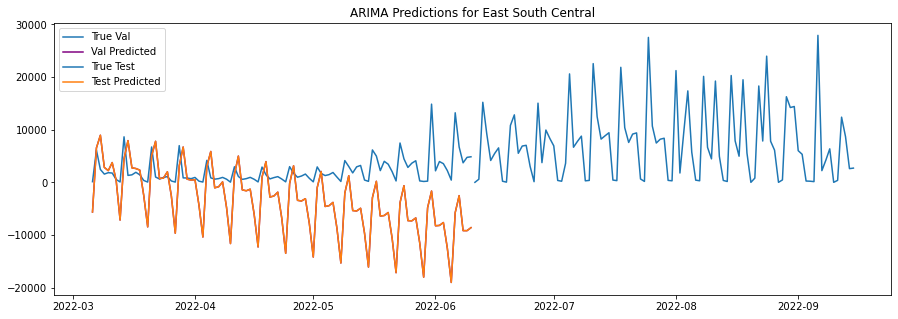


Training model for Mid-Atlantic...
Validatation Stats= AIC: 15221.08, MASE: 7.17, RMSE: 18621.0, MAE: 15324.2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.91191D+00    |proj g|=  8.23082D-02


 This problem is unconstrained.



At iterate    5    f=  9.85067D+00    |proj g|=  1.07220D-01

At iterate   10    f=  9.82670D+00    |proj g|=  7.91274D-03

At iterate   15    f=  9.82610D+00    |proj g|=  1.64731D-03

At iterate   20    f=  9.82582D+00    |proj g|=  6.79143D-03

At iterate   25    f=  9.82491D+00    |proj g|=  2.46199D-02

At iterate   30    f=  9.82017D+00    |proj g|=  1.84196D-02

At iterate   35    f=  9.81922D+00    |proj g|=  1.89079D-02

At iterate   40    f=  9.81869D+00    |proj g|=  9.07273D-03

At iterate   45    f=  9.81859D+00    |proj g|=  1.22694D-02

At iterate   50    f=  9.81853D+00    |proj g|=  1.28545D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

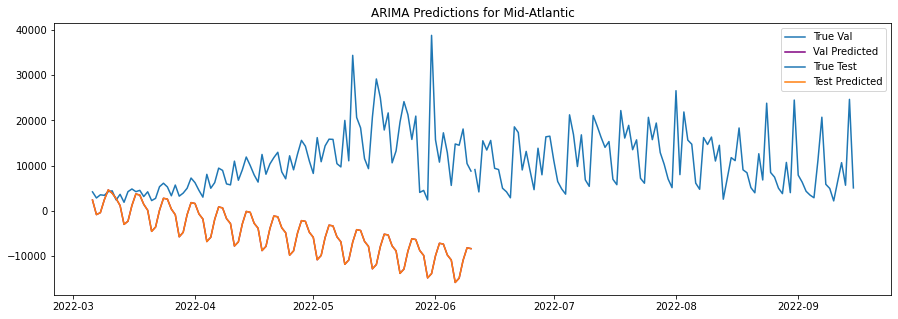


Training model for Mountain...
Validatation Stats= AIC: 15439.8, MASE: 4.79, RMSE: 18504.18, MAE: 15097.98
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01065D+01    |proj g|=  1.98628D-01


 This problem is unconstrained.



At iterate    5    f=  1.00297D+01    |proj g|=  1.16159D-01

At iterate   10    f=  9.97244D+00    |proj g|=  3.18672D-02

At iterate   15    f=  9.96881D+00    |proj g|=  1.13054D-02

At iterate   20    f=  9.96786D+00    |proj g|=  4.47025D-03

At iterate   25    f=  9.96244D+00    |proj g|=  1.74669D-02

At iterate   30    f=  9.96107D+00    |proj g|=  3.74129D-03

At iterate   35    f=  9.96008D+00    |proj g|=  5.86945D-03

At iterate   40    f=  9.95982D+00    |proj g|=  2.03485D-04

At iterate   45    f=  9.95982D+00    |proj g|=  5.06741D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     48     55   

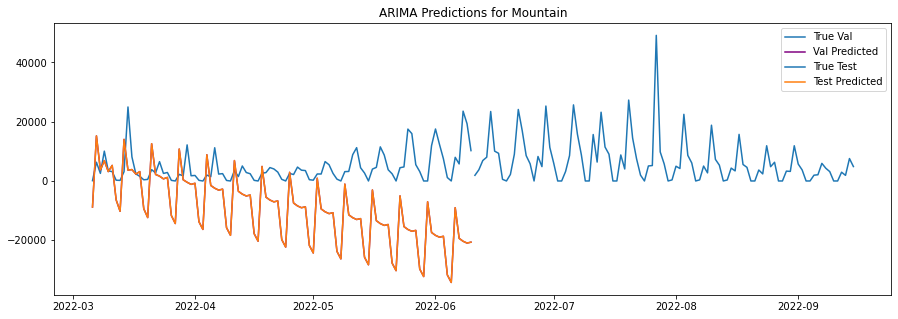


Training model for New England...
Validatation Stats= AIC: 15185.73, MASE: 3.09, RMSE: 9280.15, MAE: 7847.57
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.91711D+00    |proj g|=  1.53885D-01


 This problem is unconstrained.



At iterate    5    f=  9.86094D+00    |proj g|=  4.96356D-02

At iterate   10    f=  9.82820D+00    |proj g|=  2.98241D-02

At iterate   15    f=  9.81713D+00    |proj g|=  4.01823D-02

At iterate   20    f=  9.80325D+00    |proj g|=  2.71046D-02

At iterate   25    f=  9.79753D+00    |proj g|=  9.16590D-03

At iterate   30    f=  9.79570D+00    |proj g|=  1.39946D-03

At iterate   35    f=  9.79569D+00    |proj g|=  2.52313D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     37     41      1     0     0   4.582D-05   9.796D+00
  F =   9.7956881374855200     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

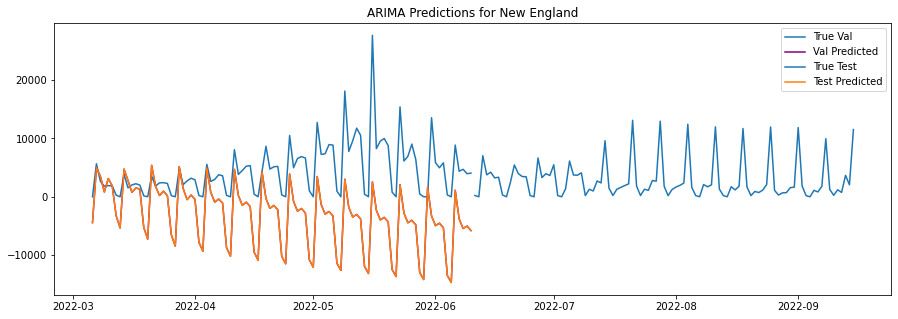


Training model for Pacific...
Validatation Stats= AIC: 16563.56, MASE: 5.29, RMSE: 44709.07, MAE: 35803.62
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07882D+01    |proj g|=  4.32848D-01


 This problem is unconstrained.



At iterate    5    f=  1.06998D+01    |proj g|=  9.22205D-03

At iterate   10    f=  1.06978D+01    |proj g|=  2.63176D-02

At iterate   15    f=  1.06883D+01    |proj g|=  1.94497D-02

At iterate   20    f=  1.06869D+01    |proj g|=  1.59041D-03

At iterate   25    f=  1.06863D+01    |proj g|=  8.24454D-03

At iterate   30    f=  1.06861D+01    |proj g|=  3.01364D-03

At iterate   35    f=  1.06860D+01    |proj g|=  3.35089D-03

At iterate   40    f=  1.06860D+01    |proj g|=  3.80151D-03

At iterate   45    f=  1.06858D+01    |proj g|=  8.58395D-03

At iterate   50    f=  1.06858D+01    |proj g|=  4.25083D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

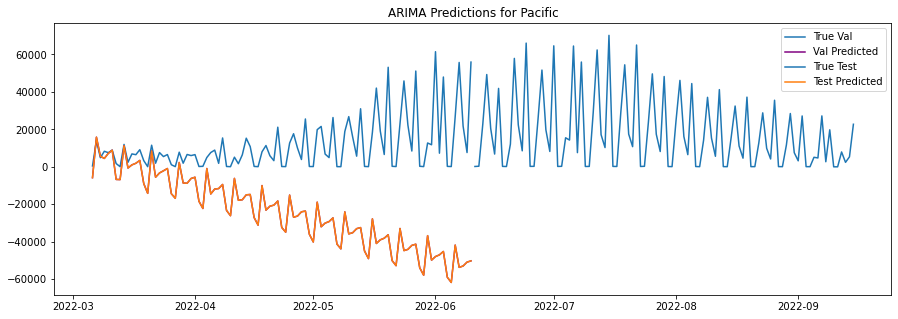


Training model for South Atlantic...
Validatation Stats= AIC: 17270.76, MASE: 5.61, RMSE: 72125.46, MAE: 60779.65
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12699D+01    |proj g|=  1.97822D-01


 This problem is unconstrained.



At iterate    5    f=  1.12021D+01    |proj g|=  5.67286D-02

At iterate   10    f=  1.11640D+01    |proj g|=  8.53317D-02

At iterate   15    f=  1.11503D+01    |proj g|=  4.10186D-02

At iterate   20    f=  1.11434D+01    |proj g|=  3.99755D-03

At iterate   25    f=  1.11431D+01    |proj g|=  3.35381D-03

At iterate   30    f=  1.11426D+01    |proj g|=  1.90213D-03

At iterate   35    f=  1.11426D+01    |proj g|=  5.90552D-04

At iterate   40    f=  1.11426D+01    |proj g|=  5.13095D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     42     64      1     0     0   5.252D-05   1.114D+01
  F =   11.142609581051895     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Test Stats= AIC: 17270.76, MASE: 6.69, RMSE: 79215.43, MAE: 71436.05


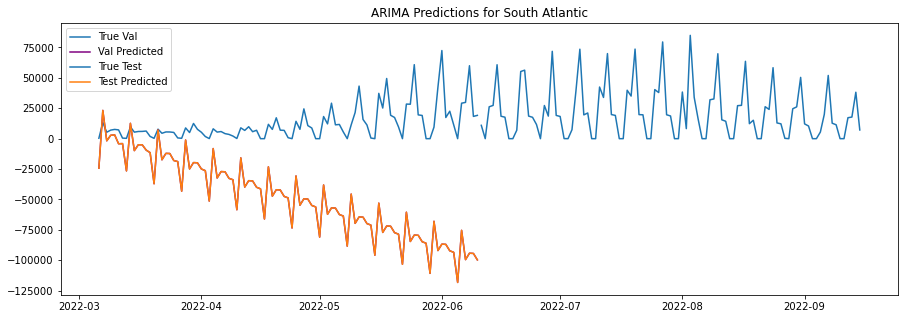


Training model for West North Central...
Validatation Stats= AIC: 15264.61, MASE: 2.12, RMSE: 8301.26, MAE: 6956.95
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.93929D+00    |proj g|=  1.20232D-01


 This problem is unconstrained.



At iterate    5    f=  9.89708D+00    |proj g|=  7.13507D-02

At iterate   10    f=  9.84830D+00    |proj g|=  7.57147D-03

At iterate   15    f=  9.84809D+00    |proj g|=  4.69386D-03

At iterate   20    f=  9.84783D+00    |proj g|=  4.68089D-04

At iterate   25    f=  9.84769D+00    |proj g|=  5.94232D-03

At iterate   30    f=  9.84753D+00    |proj g|=  1.74306D-03

At iterate   35    f=  9.84749D+00    |proj g|=  9.66668D-04

At iterate   40    f=  9.84727D+00    |proj g|=  8.05927D-03

At iterate   45    f=  9.84682D+00    |proj g|=  5.02633D-03

At iterate   50    f=  9.84665D+00    |proj g|=  1.76700D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

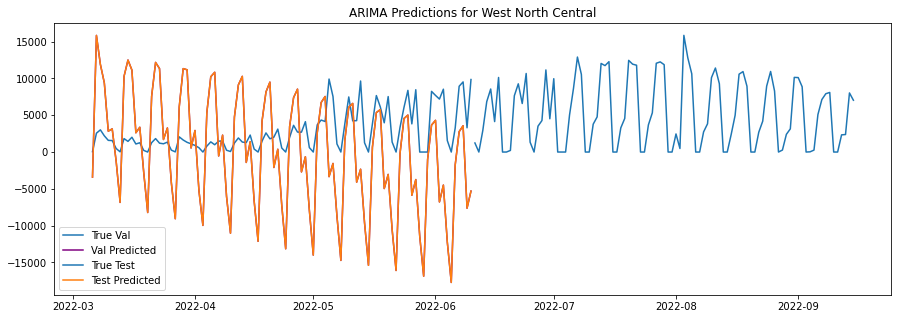


Training model for West South Central...
Validatation Stats= AIC: 16119.79, MASE: 1.93, RMSE: 10978.18, MAE: 8801.33
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04960D+01    |proj g|=  5.83857D-02


 This problem is unconstrained.



At iterate    5    f=  1.04398D+01    |proj g|=  8.71667D-02

At iterate   10    f=  1.04163D+01    |proj g|=  1.68275D-02

At iterate   15    f=  1.04146D+01    |proj g|=  1.22924D-02

At iterate   20    f=  1.04072D+01    |proj g|=  2.01469D-02

At iterate   25    f=  1.04046D+01    |proj g|=  1.52548D-02

At iterate   30    f=  1.04016D+01    |proj g|=  2.73326D-02

At iterate   35    f=  1.04004D+01    |proj g|=  2.29557D-02

At iterate   40    f=  1.03992D+01    |proj g|=  7.91496D-03

At iterate   45    f=  1.03991D+01    |proj g|=  2.60953D-03

At iterate   50    f=  1.03991D+01    |proj g|=  4.59036D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

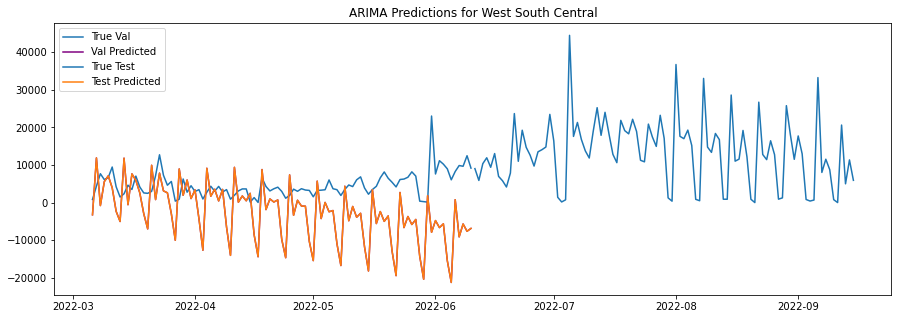


--- 272.73 seconds ---


In [25]:
start_time = time.time()
for df in datasets:
    build_baseline_model(df, plot=True, test_perf=True)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

# Parameter Optimization on Validation

In [30]:
def parameter_tune(df):
    region = df["region"].iloc[0]
    print(f"Optimizing model for {region}...")

    train_df, temp_test_df = train_test_split(df, test_size=0.2, shuffle=False)
    val_df, test_df  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)

    train = train_df['new_confirmed']
    test = test_df['new_confirmed']
    val = val_df['new_confirmed']
    train_val = pd.concat([train, val])
    # validation step
    


    results = []
    for p in range(2):
        for q in range(2):
            for P in range(3):
                for Q in range(3):
                    try:
                        model = SARIMAX(train, order=(p, 1, q), seasonal_order=(P, 1, Q, 7))
                        model_fit = model.fit(disp=False)

                        # pred = model_fit.forecast(steps=size)

                        val_pred = model_fit.forecast(steps=len(val))
            
                        mae = round(mean_absolute_error(val, val_pred), 2)
                        rmse = round(mean_squared_error(val, val_pred, squared=False), 2)
                        mase = round(mean_absolute_scaled_error(val, val_pred, y_train=train), 2)
                        aic = round(model_fit.aic, 2)

                        results.append([p, q, P, Q, aic, mae, rmse, mase])
                    except:
                        continue
                
    results = pd.DataFrame(results, columns=["p", "q", "P", "Q", "aic", "mae", "rmse", "mase"])
    results.sort_values(by="mase", inplace=True)
    print(results.head())

In [31]:
start_time = time.time()
for df in datasets:
    parameter_tune(df)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Optimizing model for East North Central...
   p  q  P  Q       aic      mae      rmse  mase
6  0  0  2  0  16715.24  7446.11  11797.83  0.91
3  0  0  1  0  16722.84  7562.71  12053.82  0.92
1  0  0  0  1  16716.60  7677.25  11908.07  0.94
0  0  0  0  0  16778.11  8178.66  12645.95  1.00
2  0  0  0  2  16719.77  8251.79  12175.48  1.01

Optimizing model for East South Central...
    p  q  P  Q       aic      mae     rmse  mase
4   0  0  1  1  16032.50  4725.82  6028.94  1.38
2   0  0  0  2  16027.73  4748.40  6053.91  1.39
17  0  1  2  2  15476.15  4999.50  6392.13  1.46
13  0  1  1  1  15525.68  5512.18  6996.41  1.61
16  0  1  2  1  15527.61  5595.08  7100.99  1.64

Optimizing model for Mid-Atlantic...
    p  q  P  Q       aic       mae      rmse  mase
2   0  0  0  2  15370.27   6805.74   9707.72  3.18
4   0  0  1  1  15379.61   6943.88   9835.32  3.25
0   0  0  0  0  15756.44   9469.31  12535.18  4.43
11  0  1  0  2  15198.73  12972.64  16146.51  6.07
5   0  0  1  2  15324.21  13736.

In [46]:
def parameter_tune2(df):
    region = df["region"].iloc[0]
    print(f"Optimizing model for {region}...")

    train_df, temp_test_df = train_test_split(df, test_size=0.2, shuffle=False)
    val_df, test_df  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)

    train = train_df['new_confirmed']
    test = test_df['new_confirmed']
    val = val_df['new_confirmed']
    train_val = pd.concat([train, val])
    # validation step
    


    results = []
    # for p in range(2):
    #     for q in range(2):
    p, q = 6, 6
    for P in range(5, 7):
        for Q in range(5, 7):
            try:
                model = SARIMAX(train, order=(p, 1, q), seasonal_order=(P, 1, Q, 7))
                model_fit = model.fit(disp=False)

                # pred = model_fit.forecast(steps=size)

                val_pred = model_fit.forecast(steps=len(val))
    
                mae = round(mean_absolute_error(val, val_pred), 2)
                rmse = round(mean_squared_error(val, val_pred, squared=False), 2)
                mase = round(mean_absolute_scaled_error(val, val_pred, y_train=train), 2)
                aic = round(model_fit.aic, 2)

                results.append([p, q, P, Q, aic, mae, rmse, mase])
            except Exception as e:
                print(e)
                continue
                
    results = pd.DataFrame(results, columns=["p", "q", "P", "Q", "aic", "mae", "rmse", "mase"])
    results.sort_values(by="mase", inplace=True)
    print(results.head())

start_time = time.time()
for df in [mid_atlantic, mountain, pacific, wsc]:
    parameter_tune2(df)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Optimizing model for Mid-Atlantic...


KeyboardInterrupt: 

## Final SARIMA

In [32]:
params = {
    "East North Central": (0, 1, 0),
    "East South Central": (0, 1, 0),
    "Mid-Atlantic": (0, 1, 0),
    "Mountain": (0, 1, 0),
    "New England": (0, 1, 0),
    "Pacific": (0, 1, 0),
    "South Atlantic": (0, 1, 0),
    "West North Central": (0, 1, 1),
    "West South Central": (0, 1, 0),
}
# D = 0
seasonal_params = {
    "East North Central": (2, 1, 0, 7),
    "East South Central": (1, 1, 1, 7),
    "Mid-Atlantic": (0, 1, 2, 7),
    "Mountain": (1, 1, 2, 7),
    "New England": (2, 1, 1, 7),
    "Pacific": (2, 1, 0, 7),
    "South Atlantic": (0, 1, 0, 7),
    "West North Central": (0, 1, 0, 7),
    "West South Central": (0, 1, 0, 7),
}

In [47]:
def sarima_final_model(df, params=None, seasonal_params=None):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    train_df, temp_test_df = train_test_split(df, test_size=0.2, shuffle=False)
    val_df, test_df  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)

    train = train_df['new_confirmed']
    test = test_df['new_confirmed']
    val = val_df['new_confirmed']
    train_val = pd.concat([train, val])


    if not params:
        params = (4, 1, 4)
    if not seasonal_params:
        seasonal_params = (1, 1, 1, 7)
    
    model = SARIMAX(train_val, order=params, seasonal_order=seasonal_params)
    model_fit = model.fit(disp=False)

    test_pred = model_fit.forecast(steps=len(val))   
    test_pred[test_pred < 0] = 0 

    # calculate metrics
    mae = round(mean_absolute_error(test, test_pred), 2)
    rmse = round(mean_squared_error(test, test_pred, squared=False), 2)
    mase = round(mean_absolute_scaled_error(test, test_pred, y_train=train_val), 2)
    aic = round(model_fit.aic, 2)

    print(f"Test Stats= AIC: {aic}, MASE: {mase}, RMSE: {rmse}, MAE: {mae}")

    

    
    # plot both validation and test
    # if plot:
    plt.figure(figsize=(15, 5))
    plt.title(f'SARIMA Predictions for {region}')
    plt.plot(test.index, test, label='True Val')
    plt.plot(test_pred.index, test_pred, label='Test Predicted')
    plt.legend() 
    plt.show()



Training model for East North Central...
Test Stats= AIC: 18747.83, MASE: 0.73, RMSE: 8218.25, MAE: 5975.24


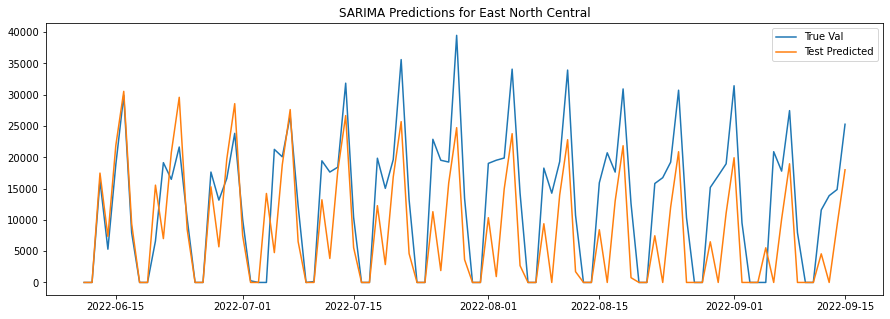


Training model for East South Central...
Test Stats= AIC: 17975.6, MASE: 1.3, RMSE: 6614.0, MAE: 4233.83


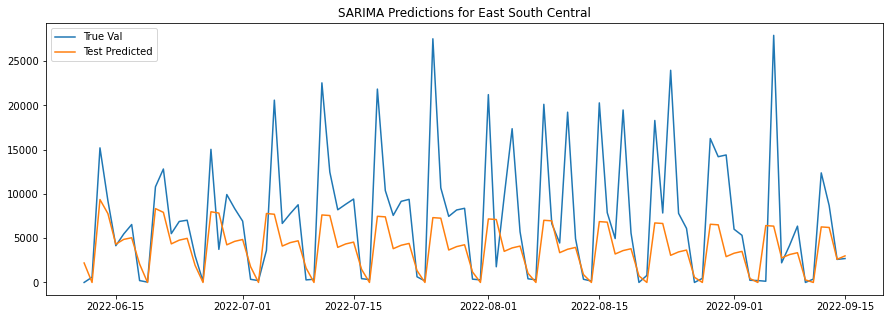


Training model for Mid-Atlantic...
Test Stats= AIC: 17411.96, MASE: 3.68, RMSE: 10551.18, MAE: 8707.46


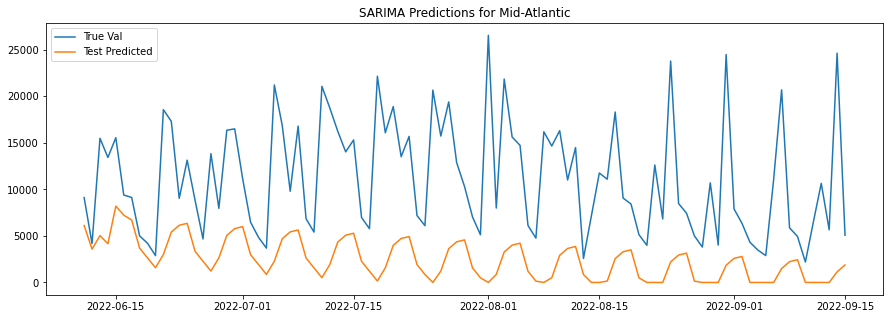


Training model for Mountain...
Test Stats= AIC: 17960.48, MASE: 3.87, RMSE: 14117.23, MAE: 12370.08


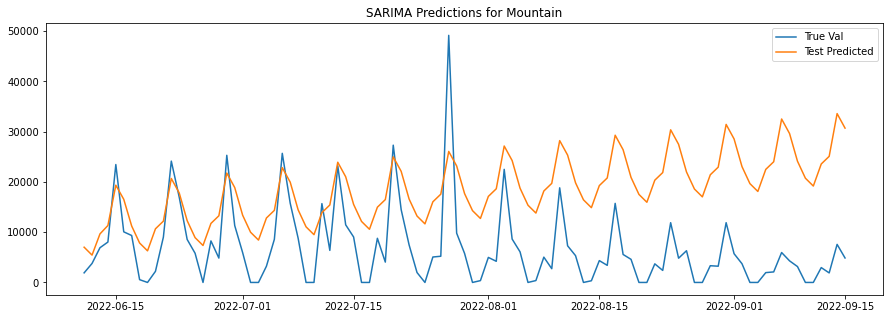


Training model for New England...
Test Stats= AIC: 17647.34, MASE: 0.9, RMSE: 4006.89, MAE: 2361.08


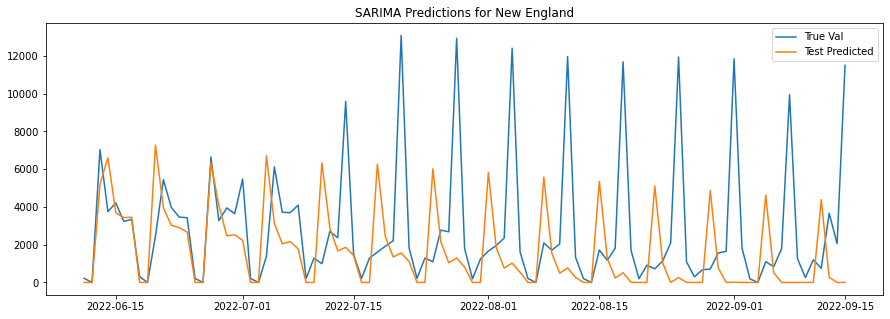


Training model for Pacific...
Test Stats= AIC: 19203.01, MASE: 6.51, RMSE: 56892.93, MAE: 48555.8


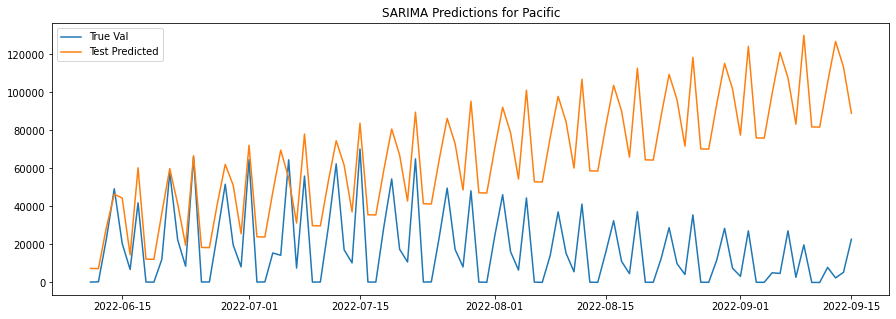


Training model for South Atlantic...
Test Stats= AIC: 20649.33, MASE: 1.35, RMSE: 19598.15, MAE: 14428.71


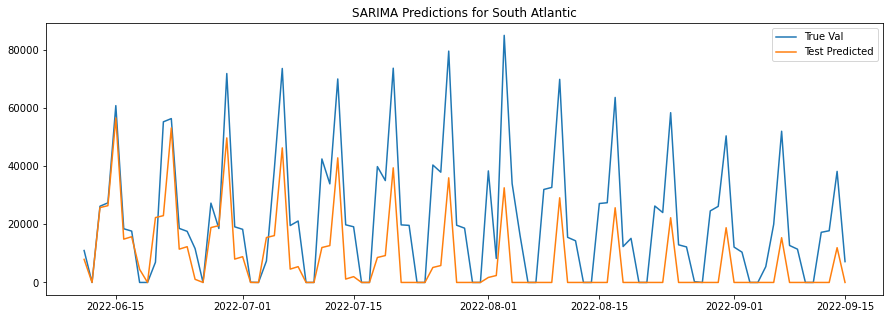


Training model for West North Central...
Test Stats= AIC: 17369.97, MASE: 1.27, RMSE: 4833.32, MAE: 3976.94


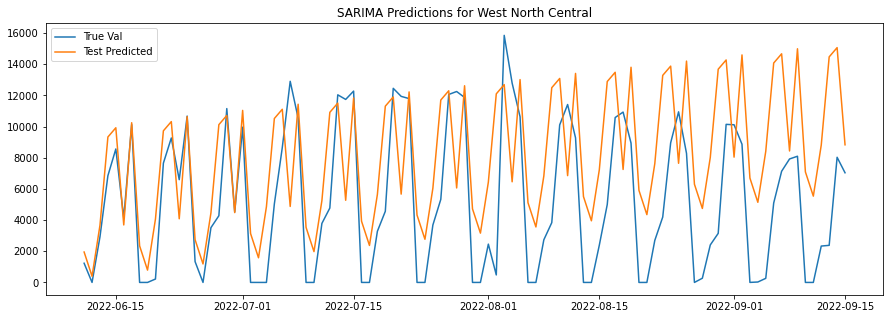


Training model for West South Central...
Test Stats= AIC: 18617.27, MASE: 2.54, RMSE: 13843.52, MAE: 10889.04


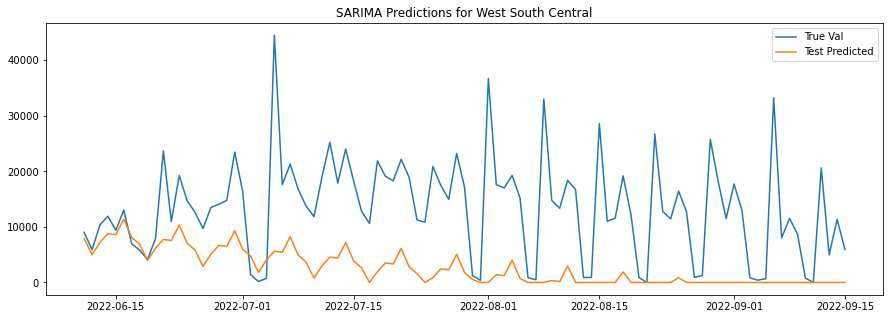


--- 33.57 seconds ---


In [48]:
start_time = time.time()
for df in datasets:
    region = [df["region"].iloc[0]][0]
    sarima_final_model(df, params=params[region], seasonal_params=seasonal_params[region])
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")